# NQ&A Prediction

In [1]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf

from scripts import nqa_utils
from scripts.nqa_utils import Answer, AnswerType
from scripts import bert_modeling as modeling
from scripts import bert_tokenization
from scripts import albert
from scripts import albert_tokenization
from scripts.models import build_model

import collections
from collections import OrderedDict, namedtuple
import copy
import itertools
import json
import absl
import sys
import os
import warnings

NQA Utils Loaded!


In [35]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(absl.flags.FLAGS)

flags = absl.flags

### Main Model Flags ###

flags.DEFINE_string(
    "model", "bert",
    "The name of model to use. Choose from ['bert', 'albert'].")

flags.DEFINE_string(
    "config_file", "models/bert_joint_baseline/bert_config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("vocab_file", "models/bert_joint_baseline/vocab-nq.txt",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "init_checkpoint", "models/bert_joint_baseline/tf2_bert_joint.ckpt",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer("predict_batch_size", 1,
                     "Total batch size for predictions.")

### Second Model Flags ###

flags.DEFINE_string(
    "second_model", "albert",
    "The name of model to use. Choose from ['albert', 'bert'].")

flags.DEFINE_string(
    "second_config_file", "models/albert_xxl/config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("second_vocab_file", "models/albert_xxl/vocab/modified-30k-clean.model",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "second_init_checkpoint", "models/albert_xxl/albert_finetuned.h5",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "second_max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "second_batch_size", 1,
    "Batch size when running verifier predictions.")

### Other Flags ###

flags.DEFINE_string(
    "output_dir", "output/",
    "The output directory where the model checkpoints will be written.")

flags.DEFINE_string(
    "train_file", "data/simplified-nq-dev.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")

flags.DEFINE_string(
    "log_dir", "logs/",
    "Where logs, specifically Tensorboard logs, will be saved to.")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_predict", True, "Whether to run eval on the dev set.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_float(
    "include_unknowns", 1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

absl.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

# TODO(Edan): Look at nested contents too at some point
# Around 5% of long answers are nested, and around 50% of questions have
# long answers
# This means that this setting alone restricts us from a correct answer
# around 2.5% of the time
flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "n_examples", 200,
    "Number of examples to read from files.")

flags.DEFINE_boolean(
    "test_post_processing", True,
    "If true, training data will be predicted for instead of eval data,"
    "and the predictions will be used to tune the post processing algorithm.")

flags.DEFINE_integer(
    "tokens_per_small_example", 105*10, # On average about 10 features
    "The amount of tokens allowed on average for an example to be considered "
    "small. Small examples are run directly through ALBERT-xxl.")

### Currently Not In Use ###

flags.DEFINE_integer(
    "max_features_per_small_example", 15,
    "The amount of features allowed for a small example before being truncated.")

flags.DEFINE_integer(
    "max_features_per_example", 65,
    "The amount of features allowed for an example before being truncated.")

## Special flags - do not change

flags.DEFINE_string(
    "predict_file", "/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

FLAGS = flags.FLAGS
FLAGS(sys.argv) # Parse the flags

N_TRAIN_EXAMPLES = 307373

# Data Formatting

In [38]:
def print_scores(scores):
    print('Total Score', '\n', scores[0], '\n')
    print('Long Answer Score', '\n', scores[1], '\n')
    print('Short Answer Score', '\n', scores[2], '\n')

In [15]:
if FLAGS.test_post_processing:
    input_file = FLAGS.train_file
    actual_answers = nqa_utils.get_actual_answers(input_file, FLAGS.n_examples)
else:
    input_file = FLAGS.predict_file
    
candidates_dict = nqa_utils.read_candidates(input_file, n=FLAGS.n_examples)

print("Predict File:", input_file)

eval_examples = nqa_utils.read_nq_examples(
      input_file=input_file, is_training=FLAGS.test_post_processing, n=FLAGS.n_examples)

id_to_example = {}
for example in eval_examples:
    id_to_example[example.example_id] = example

raw_examples = next(nqa_utils.raw_data_generator(input_file, FLAGS.n_examples))
raw_examples = [dict(row) for _, row in raw_examples.iterrows()]

final_answers = {}

Predict File: data/simplified-nq-dev.jsonl


# Prediction Part 1: ALBERT Small Examples

In [5]:
### Get the Small Examples ###

small_examples = []
remaining_examples = []

n_total_tokens = 0
n_total_examples = 0
sorted_examples = sorted(eval_examples, key=lambda x: len(x.doc_tokens))
for example in sorted_examples:
    n_tokens = len(example.doc_tokens)
    n_total_tokens += n_tokens
    n_total_examples += 1
    
    if n_total_examples and n_total_tokens and \
        n_total_tokens / n_total_examples >= FLAGS.tokens_per_small_example:
        break
        
small_examples = sorted_examples[:n_total_examples]
remaining_examples = sorted_examples[n_total_examples:]
# small_examples = eval_examples

if FLAGS.second_model == 'bert':
    tokenizer_small = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
    lowercase = False
elif FLAGS.second_model == 'albert':
    tokenizer_small = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.second_vocab_file)
    lowercase = True

def append_feature_small(feature):
    eval_features_small.append(feature)
    eval_writer_small.process_feature(feature)

eval_writer_small = nqa_utils.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_small.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features_small = []

nqa_utils.convert_examples_to_features(
  examples=small_examples,
  tokenizer=tokenizer_small,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature_small,
  lowercase=lowercase)

eval_writer_small.close()
eval_filename_small = eval_writer_small.filename

print('# Small Examples:', len(small_examples))
print('# Features:', len(eval_features_small))

# Small Examples: 72
# Features: 681


# Build Model and Run Predictions

In [6]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

In [9]:
n_steps = np.ceil(eval_writer_small.num_features / FLAGS.second_batch_size)
generator = nqa_utils.data_generator(eval_filename_small, FLAGS.second_batch_size)

preds_small = model.predict(generator, steps=n_steps)
final_answers.update(preds_small)

In [34]:
import importlib
importlib.reload(nqa_utils)

NQA Utils Loaded!


<module 'scripts.nqa_utils' from '/home/ejmejm/MLProjects/kaggle-nqa/scripts/nqa_utils.py'>

In [59]:
weights = {
    'ans_type_conf_weight': 0.1,
    'start_pos_conf_weight': 0.45,
    'end_pos_conf_weight': 0.45,
    'conf_bias': 0.0,
    'conf_threshold': 0.94
}

answers_small = nqa_utils.compute_answers(preds_small, candidates_dict,\
                                          eval_features_small, small_examples,
                                          id_to_example, weights)
final_answers.update(answers_small)

if FLAGS.test_post_processing:
    print_scores(nqa_utils.score_preds(raw_examples, answers_small))

Total Score 
 F1 = 0.702 | Recall = 0.678 | Precision = 0.727 | TP = 40 | FP = 19 | FN = 15 | TN = 70 

Long Answer Score 
 F1 = 0.708 | Recall = 0.697 | Precision = 0.719 | TP = 23 | FP = 10 | FN = 9 | TN = 30 

Short Answer Score 
 F1 = 0.694 | Recall = 0.654 | Precision = 0.739 | TP = 17 | FP = 9 | FN = 6 | TN = 40 



# Prediction Part 2: BERT-Joint Remaining Examples

In [62]:
if FLAGS.model == 'bert':
    tokenizer = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)
elif FLAGS.model == 'albert':
    tokenizer = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.vocab_file)

eval_writer = nqa_utils.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_remaining.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features = []

def append_feature(feature):
    eval_features.append(feature)
    eval_writer.process_feature(feature)

nqa_utils.convert_examples_to_features(
  examples=remaining_examples,
  tokenizer=tokenizer,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature)
eval_writer.close()
eval_filename = eval_writer.filename

print('# Remaning Examples:', len(remaining_examples))
print('# Features:', len(eval_features))

# Remaning Examples: 128
# Features: 4734


In [61]:
# nf_map = {}
# for f in eval_features:
#     if f.example_index in nf_map:
#         nf_map[f.example_index] += 1
#     else:
#         nf_map[f.example_index] = 1

# n_tokens_to_features = []
# for example in eval_examples:
#     n_tokens = len(example.doc_tokens)
#     n_features = nf_map[example.example_id]
#     n_tokens_to_features.append((n_tokens, n_features))
    
# print(pd.Series([x[0] / x[1] for x in n_tokens_to_features]).describe())

# sns.scatterplot([x[0] for x in n_tokens_to_features], [x[1] for x in n_tokens_to_features])

## Build the Model

In [6]:
model = build_model(model_name=FLAGS.model,
                    config_file=FLAGS.config_file,
                    max_seq_length=FLAGS.max_seq_length,
                    init_ckpt=FLAGS.init_checkpoint)
model.summary()

Model: "bert_baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
bert (BertModel)                ((None, 1024), (None 335141888   input_ids[0][0]                  
                                                                 input_mask[0][0]     

In [7]:
n_steps = np.ceil(eval_writer.num_features / FLAGS.predict_batch_size)
generator = data_generator(eval_filename, FLAGS.predict_batch_size)

preds = model.predict_generator(generator, steps=n_steps)

# Compute the Answers

In [13]:
weights = {
    'ans_type_conf_weight': 0.4,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.3,
    'conf_bias': 0.0,
    'conf_threshold': 0.97
}

answers = compute_answers(preds, candidates_dict, eval_features, eval_examples, id_to_example, weights)

/home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: Original to document index mapping could not be resolved!


# Compute the Micro-F1 Score

In [14]:
if FLAGS.test_post_processing:
    micro_f1, recall, precision, details = score_preds(actual_answers, answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)

Micro F1 Score: 0.5315068493150685
Recall: 0.9238095238095239
Precision: 0.3730769230769231
{'TP': 97, 'FP': 163, 'FN': 8, 'FP_WA': 56, 'FP_NA': 107}


In [15]:
score_preds_2(raw_examples, answers)

('TP = 95   FP = 165   FN = 7   TN = 133   F1 = 0.52',
 'TP = 62   FP = 90   FN = 4   TN = 44   F1 = 0.57',
 'TP = 33   FP = 75   FN = 3   TN = 89   F1 = 0.46')

# Grid Search to Select the Best Parameters for Postprocessing

In [16]:
if False:
    default_range = np.arange(0, 1.05, 0.5)

    weight_ranges = OrderedDict({
            'ans_type_conf_weight': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'start_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'end_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'conf_bias': [-0.5, -0.25, 0, 0.25, 0.5],
            'conf_threshold': [0.5]
        })

    combinations = list(itertools.product(*[weight_ranges[k] for k in weight_ranges.keys()]))

    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)

    results = {}
    for weight_vals in tqdm.tqdm(combinations):
        weights = {}
        for weight_name, weight_val in zip(weight_ranges.keys(), weight_vals):
                weights[weight_name] = weight_val

        tmp_answers = compute_answers(preds, candidates_dict, eval_features, weights)
        micro_f1, recall, precision, _ = score_preds(actual_answers, tmp_answers)
        results[weight_vals] = (micro_f1, recall, precision)
        
    sr = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    print(sr[:20])

# Answers Data Analysis

### Things to explore (WIP)
- Can we accurately order the answers in terms of confidence?
- Is a series of segments all with answers a good predictor for an actual answer in that block?
- What does the general spread of probabilities look like when there is an answer?
- What about the spread of probabilities when there is no answer?




- If 1, 2, and 3 are in a row, choose the middle one

In [17]:
def in_range(first, second):
    return first[0] >= second[0] and first[1] <= second[1]

In [18]:
avg_n_features = 0
ordering_reg_data = [] # (predicted rank of answer, whether there actually is answer at that feature)
n_preds_data = [] # (percent of features that predict an answer, whether there is actually an answer)

for example_id in answers.keys():
    pred_answer = answers[example_id]
    actual_answer = actual_answers[example_id]
    
    if not pred_answer['ordered_entries']:
        continue
    
    avg_n_features += id_to_example[example_id].n_features
    entries_pred = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    actual_oh = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    for entry_idx, entry in enumerate(pred_answer['ordered_entries']):
        feature = entry['feature']
        entries_pred[feature.doc_span_index] = entry_idx + 1
        
        tok_to_orig_map = entry['feature'].token_to_orig_map
        feature_min_idx = min(tok_to_orig_map.values(), key=lambda x: x if x != -1 else 99999)
        feature_max_idx = max(tok_to_orig_map.values())
        target_answers = actual_answer['long_answers']
        if isinstance(actual_answer['short_answers'], tuple):
            target_answers = actual_answer['short_answers']
        if target_answers:
            for tgt in target_answers:
                if in_range(tgt, (feature_min_idx, feature_max_idx)):
                    actual_oh[feature.doc_span_index] = 1
                    break
     
    percent_preds = len(pred_answer['ordered_entries']) / id_to_example[example_id].n_features
    exists_answer = int(1 in actual_oh)
    n_preds_data.append((percent_preds, exists_answer))
    
    for x, y in zip(entries_pred, actual_oh):
        if x != 0 or y != 0:
            ordering_reg_data.append((x, y))
    
    print(entries_pred)
    print(actual_oh)
    print()

print('Avg # features per example:', avg_n_features / len(answers.keys()))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 5  3 15 12  0  2  1  0  0  6  0 14 11  0 10  0  0  0  0  9 13  8  7  4
  0  0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[3 0 2 1 0 5 0 6 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 0 1 3 2 7 6 8 9 0 5 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 

In [11]:
import matplotlib as plt
import seaborn as sns

%matplotlib inline
sns.set()

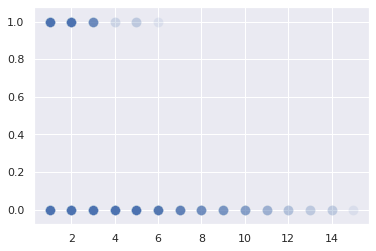

In [20]:
sns.scatterplot([x[0] for x in ordering_reg_data], [x[1] for x in ordering_reg_data], s=100, alpha=0.1)

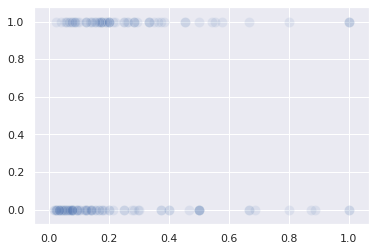

In [21]:
sns.scatterplot([x[0] for x in n_preds_data], [x[1] for x in n_preds_data], s=100, alpha=0.1)

# Generate Features for the Second Model

In [47]:
if FLAGS.do_predict:
    if FLAGS.second_model == 'bert':
        tokenizer_2 = bert_tokenization.FullTokenizer(
            vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
    elif FLAGS.second_model == 'albert':
        tokenizer_2 = albert_tokenization.FullTokenizer(
            None, spm_model_file=FLAGS.second_vocab_file)

    if FLAGS.test_post_processing:
        input_file = FLAGS.train_file
    else:
        input_file = FLAGS.predict_file

    eval_writer_2 = nqa_utils.FeatureWriter(
      filename=os.path.join(FLAGS.output_dir, "eval_2.tf_record"),
      is_training=FLAGS.test_post_processing)
    eval_features_2 = []
    
    def append_feature_2(feature):
        eval_features_2.append(feature)
        eval_writer_2.process_feature(feature)
    
    # Limit examples to only those that are not unknown answers
    eval_examples_2 = [example for example in eval_examples if answers[example.example_id]['long_answer']]

    for target_rank in range(8):
        # Get the document token index ranges of the desired answers
        n_extra_tokens = 30
        answer_ranges = []
        curr_examples = []
        for example in eval_examples_2:
            answer = answers[example.example_id]
            if target_rank >= len(answer['ordered_entries']):
                continue
            entry = answer['ordered_entries'][target_rank]

            doc_start_idx = entry['doc_tokens_start_idx']
            doc_end_idx = entry['doc_tokens_end_idx']

            answer_ranges.append((max(0, doc_start_idx - n_extra_tokens),
                                  min(len(example.doc_tokens), doc_end_idx + n_extra_tokens)))
            
            curr_examples.append(example)

        convert_partial_examples_to_features(
            examples=eval_examples_2,
            ranges=answer_ranges,
            tokenizer=tokenizer_2,
            is_training=FLAGS.test_post_processing,
            output_fn=append_feature_2)

    eval_writer_2.close()
    eval_filename_2 = eval_writer_2.filename

    print('# Examples (2):', len(eval_examples_2))
    print('# Features (2):', len(eval_features_2))

    print('**Features**\n')

    for e in dir(eval_features_2[0]):
        if not e.startswith('__'):
            print(e)

# Examples (2): 152
# Features (2): 473
**Features**

answer_text
answer_type
doc_span_index
end_position
example_index
input_ids
input_mask
segment_ids
start_position
token_is_max_context
token_to_orig_map
tokens
unique_id


# Build the Second Model

In [48]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

# Run Predictions with the Second Model

In [49]:
n_steps = np.ceil(eval_writer_2.num_features / FLAGS.second_batch_size)
generator = data_generator(eval_filename_2, FLAGS.second_batch_size)

preds_2 = model.predict(generator, steps=n_steps)

# Compute New Answers

In [50]:
invalid_input_ids_2 = tokenizer_2.convert_tokens_to_ids(['[Q]', '[SEP]', '[CLS]', '[PAD]'])

weights_2 = {
    'ans_type_conf_weight': 0.6,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.1,
    'conf_bias': 0.0,
    'conf_threshold': 0.8
}

second_answers = compute_answers(preds_2, 
                                 candidates_dict, 
                                 eval_features_2, 
                                 eval_examples_2, 
                                 id_to_example,
                                 weights=weights_2,
                                invalid_input_ids=invalid_input_ids_2)

final_answers = copy.copy(answers)
final_answers.update(second_answers)

if FLAGS.test_post_processing:
#     actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)
    micro_f1, recall, precision, details = score_preds(actual_answers, final_answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)
    
    print()
    
    for x in score_preds_2(raw_examples, final_answers):
        print(x)

Micro F1 Score: 0.662379421221865
Recall: 0.824
Precision: 0.553763440860215
{'TP': 103, 'FP': 83, 'FN': 22, 'FP_WA': 36, 'FP_NA': 47}

TP = 101   FP = 85   FN = 21   TN = 193   F1 = 0.66
TP = 60   FP = 45   FN = 15   TN = 80   F1 = 0.67
TP = 41   FP = 40   FN = 6   TN = 113   F1 = 0.64


In [51]:
[{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} for a in second_answers.values()]

[{'long_answer': (2861, 2943), 'short_answer': (2893, 2906)},
 {'long_answer': (176, 245), 'short_answer': (238, 240)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (75, 186), 'short_answer': (85, 86)},
 {'long_answer': (946, 1147), 'short_answer': (972, 973)},
 {'long_answer': (83, 406), 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (323, 379), 'short_answer': (360, 364)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (603, 655), 'short_answer': (651, 653)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (723, 827), 'short_answer': (739, 740)},
 {'long_answer': (3524, 3608), 'short_answer': (3534, 3535)},
 {'long_answer': (66, 155), 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (245, 335), 'short_answer': (246, 249)},
 {

In [28]:
simple_answers = [{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} \
    for a in second_answers.values()]

has_ans_perc = sum([1 for a in simple_answers if a['long_answer']]) / len(simple_answers)
print('Has answer percent: {:.2f}%'.format(has_ans_perc * 100))

n_la = 0
n_sa = 0
n_la_matches = 0
n_sa_matches = 0
for example_id in second_answers.keys():
    answer1 = answers[example_id]
    answer2 = second_answers[example_id]
    if answer2['long_answer']:
        n_la += 1
        if answer1['long_answer'] == answer2['long_answer']:
            n_la_matches += 1
            
    if answer2['short_answer']:
        n_sa += 1
        if answer1['short_answer'] == answer2['short_answer']:
            n_sa_matches += 1
            
print('Long answer agreement: {:.2f}%'.format(n_la_matches/n_la * 100))
print('Short answer agreement: {:.2f}%'.format(n_sa_matches/n_sa * 100))

Has answer percent: 67.11%
Long answer agreement: 83.33%
Short answer agreement: 60.76%


In [29]:
if FLAGS.test_post_processing:
    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)
    micro_f1, recall, precision, details = score_preds(actual_answers, final_answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)

Micro F1 Score: 0.6179401993355482
Recall: 0.775
Precision: 0.5138121546961326
{'TP': 93, 'FP': 88, 'FN': 27, 'FP_WA': 41, 'FP_NA': 47}


# Grid Search for Postprocessing Parameters

In [30]:
if False:
    weight_ranges = OrderedDict({
            'ans_type_conf_weight': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
            'start_pos_conf_weight': [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4],
            'end_pos_conf_weight': [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4],
            'conf_bias': [-0.2, -0.1, 0, 0.1, 0.2],
            'conf_threshold': [0.5]
        })

    combinations = list(itertools.product(*[weight_ranges[k] for k in weight_ranges.keys()]))

    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)

    results = {}
    for weight_vals in tqdm.tqdm(combinations):
        weights_2 = {}
        for weight_name, weight_val in zip(weight_ranges.keys(), weight_vals):
                weights_2[weight_name] = weight_val
                
        tmp_answers = compute_answers(preds_2, 
                                      candidates_dict, 
                                      eval_features_2, 
                                      eval_examples_2, 
                                      id_to_example,
                                      weights=weights_2,
                                      invalid_input_ids=invalid_input_ids_2)
        tmp_final_answers = copy.copy(answers)
        tmp_final_answers.update(tmp_answers)
        
        micro_f1, recall, precision, _ = score_preds(actual_answers, tmp_final_answers)
        results[weight_vals] = (micro_f1, recall, precision)
        
    sr = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    print(sr[:20])

### BERT Joint Baseline
    - F1: 0.564
    - Recall: 0.850
    - Precision: 0.422
    
    On 2000 dev examples:
    - F1: 0.524
    
### BERT Joint + ALBERT Finetuned
    - F1: 0.628
    - Recall: 0.667
    - Precision: 0.593
    
    On 2000 dev examples:
    
    'ans_type_conf_weight': 0.6,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.1,
    'conf_bias': 0.0,
    'conf_threshold': 0.8
        
    - F1: 0.613
    
### ALBERT Finetuned
    - F1: 0.791
    - Recall: 0.895
    - Precision: 0.708

## Function to Create a Submission

In [31]:
def create_submission(answers):
    submission_data = []

    # Loop through answers in alphabetic order of example_ids
    # This is how it's sorted in the sample submission
    for example_id, answer in sorted(answers.items(), key=lambda x: x[0]):
        long_answer_text = ''
        if isinstance(answer['long_answer'], tuple):
            long_answer_text = f'{answer["long_answer"][0]}:{answer["long_answer"][1]}'
        else:
            assert answer['long_answer'] is None, 'Invalid type of long answer!'
            assert answer['short_answer'] is None, 'Cannot have a short answer with no long answer!'
        long_answer_row = [f'{example_id}_long', long_answer_text]

        short_answer_text = ''
        if isinstance(answer['short_answer'], tuple):
            short_answer_text = f'{answer["short_answer"][0]}:{answer["short_answer"][1]}'
        elif answer['short_answer'] in ('YES', 'NO'):
            short_answer_text = answer['short_answer']
        else:
            assert answer['short_answer'] is None, 'Invalid type of short answer!'
        short_answer_row = [f'{example_id}_short', short_answer_text]

        submission_data.append(long_answer_row)
        submission_data.append(short_answer_row)

    submission_df = pd.DataFrame(submission_data, columns=['example_id', 'PredictionString'])
    return submission_df

# Create and Save the Submission!

In [32]:
if not FLAGS.test_post_processing:
    submission_df = create_submission(answers)
    print(submission_df.head())
    submission_df.to_csv('submission.csv', index=False)